In [1]:
import os
import numpy as np
import pandas as pd
import re
import pickle
import matplotlib.pyplot as plt

In [2]:
# path
cur_path = os.getcwd()
file_path = cur_path + "\Documents\\technical-assignment-2020-0823"
train_data_path = file_path + '\\train_data'
train_label_path = file_path + '\\train_label'

In [3]:
# read train data
train_data = pd.read_csv(train_data_path, sep='\n', names=["review"], header=None, skip_blank_lines=False)
train_label = pd.read_csv(train_label_path, sep='\n', names=["rate"], header=None)

In [4]:
train = pd.concat([train_data, train_label], axis=1)

In [5]:
# drop invalid data
train.drop_duplicates(subset=['review'], inplace=True)

# replace all other string to blank except korean
train['review'] = train['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train['review'].replace('', np.nan, inplace=True)
train = train.dropna(how = 'any')

print('전처리 후 샘플의 개수 :',len(train))

전처리 후 샘플의 개수 : 8422167


In [6]:
# 훈련데이터 세트 분할
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train["review"], train["rate"], stratify=train["rate"], test_size=0.01, random_state=1)

<AxesSubplot:>

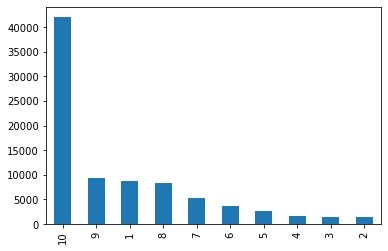

In [7]:
# 적은 부분
train = pd.concat([x_test, y_test], axis=1)
train['rate'].value_counts().plot(kind = 'bar')

In [8]:
# 많은 부분
rest = pd.concat([x_train, y_train], axis=1)

len(rest)

8337945

In [9]:
file = file_path + "\\rest1.csv"
rest.to_csv(file)

In [10]:
from konlpy.tag import Okt
okt = Okt()

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [11]:
# 토큰화 객체 계속 쓰기
X_train = []
for sentence in train['review']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)
print(len(X_train))

84222


In [12]:
print(X_train[:5])

[['영화', '너무', '길다', '이렇다', '영화', '이런', '류', '좋아하다', '인간', '만', '볼', '만', '영화', '임'], ['늦다', '보다', '감다', '재밌다', '보다'], ['대한민국', '영화', '혁명', '영화', '그', '자체', '영화', '대통령'], ['스타', '뎀', '영화', '팬', '이라', '기꺼이', '보다', '팬', '아니다', '굳이', '극장', '에서', '보라', '고', '추천', '하고', '싶다', '않다'], ['초', '중반', '조금', '지루하다', '가다', '엇', '지다', '다시', '보다', '영화', '이다', '엔딩', '좋다', 'ㅎㅎ', '두번째', '볼때', '영화', '푹', '빠지다', '보다', '꿈꾸다', '같다', '느낌', '낭만', '적', '인', '영화', '에요']]


In [14]:
print(len(X_train), len(train['rate']))

84222 84222


In [16]:
y_train = train['rate'].to_numpy()

In [19]:
# 토큰화 객체 저장
with open('tokenized_data1.p', 'wb') as file:
    pickle.dump(X_train, file)
    
with open('data1_label.p', 'wb') as file:
    pickle.dump(y_train, file)

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [17]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29531
등장 빈도가 2번 이하인 희귀 단어의 수: 17187
단어 집합에서 희귀 단어의 비율: 58.19985777657377
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.3858058875623716


In [18]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 12346


In [19]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)

In [21]:
y_train = np.array(train['rate'])

In [22]:
# 빈 샘플 제거
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

84090
84090


C:\Users\yhc\anaconda3\envs\py37\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


리뷰의 최대 길이 : 61
리뷰의 평균 길이 : 10.500820549411346


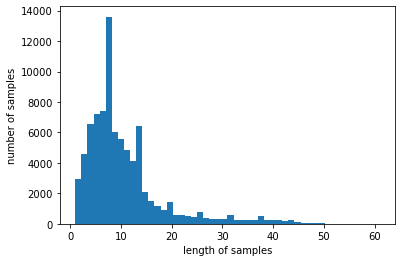

In [27]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [29]:
# 최대 길이 설정
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

max_len = 30
below_threshold_len(max_len, X_train)

X_train = pad_sequences(X_train, maxlen = max_len)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 95.79854917350458


In [33]:
# 토큰화 객체 저장
with open('tokenized_data1.p', 'wb') as file:
    pickle.dump(X_train, file)
    
with open('data1_label.p', 'wb') as file:
    pickle.dump(y_train, file)

In [39]:
# 토큰화 객체 불러오기
with open('tokenized_data1.p', 'rb') as file:
    X_train = pickle.load(file)
    
with open('data1_label.p', 'rb') as file:
    y_train = pickle.load(file)
    
print(len(X_train))
print(len(y_train))

84090
84090
